In [1]:
%matplotlib inline
from skimage import io, filters
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from lgan.diffeomorphism import tf_diffeomorphism

/home/dorian/.local/lib/python3.5/site-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')


In [12]:
batch_size = 64 #batch size
input_dim = 784 #dim x and z input_size

#mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train = mnist.train.images
Y_train = mnist.train.labels
X_train = X_train.reshape(55000,28,28,1)

#reorganize labels
y_train = np.zeros(55000)
for i in range(len(Y_train)):
    y_train[i]= np.argwhere(Y_train[i]==1)#reshape

#create mean Images
numberImages = np.zeros((10,28,28,1))
for i in range(10):
    numbers = np.argwhere(y_train==i)
    z = X_train[numbers] #collect all images with number    
    numberImages[i] = np.mean(z, axis=0)

X_train = X_train.reshape(55000,784)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 28, 28, 1)


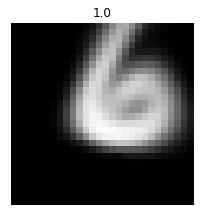

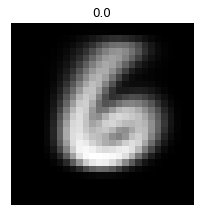

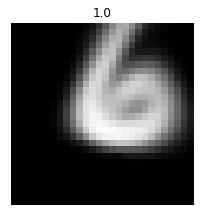

In [42]:
#try Diffeomorphism
image = numberImages[6]
image = np.reshape(image, (1,28,28,1))
print(image.shape)
session = tf.InteractiveSession()
diff_map =  np.random.uniform(-0.6,0.6, size=(1,2, 2, 2)) #batch_size, diff_height, diff_width, 2
dif_image = tf_diffeomorphism(image,diff_map)
plot(image,np.zeros(1))
div_image = dif_image.eval()
plot(div_image,np.ones(1))



In [26]:
#simple plot function
def plot(samples, labels):
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1.3,
                wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.title(labels[i])
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')   
    return fig

In [ ]:
#sample for Generator: Random Mean Images 0-9 + Uniform Noise Vector + Label
def sample_z(batch_size):
    batch = np.zeros((batch_size,input_dim))
    labels = np.zeros((batch_size,))
    for i in range(batch_size-1):
        vector = np.random.uniform(-1., 1., size=[input_dim])/20
        index = int(np.random.rand(1)*10)
        number = np.reshape(numberImages[index],784)
        z_im = number+vector
        batch[i]=z_im
        labels[i]=index
    return (batch,labels)

In [ ]:
def generator(z):
    with tf.variable_scope('generator'):
        z = tf.reshape(z,[-1,28,28,1])
        net = slim.conv2d(z, 32, [3, 3],2, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_1',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 64, [3, 3],1, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_2',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.convolution2d_transpose(net, 32, [3,3],2, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_3',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 1, [1,1],1, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                          scope='convG_4',padding = 'SAME')
        G_prob = tf.nn.tanh(net)
        return G_prob


def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[-1,28,28,1])
        #net = slim.conv2d(x, 128, [3, 3], weights_initializer=tf.contrib.layers.xavier_initializer(), scope='convD_1')
        #net = slim.batch_norm(net)
        #net = tf.nn.relu(net)
        net = slim.conv2d(x, 32, [3, 3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_2',padding = 'SAME')
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 64, [3, 3],1,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_3',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.convolution2d_transpose(net, 32, [3,3],2, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_4',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = slim.conv2d(net, 16, [3,3],1, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_5',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        return slim.fully_connected(net, num_outputs = 1,weights_initializer=tf.truncated_normal_initializer(stddev=0.1))


In [ ]:
#Session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


#input
X = tf.placeholder(tf.float32, shape=[None, input_dim]) 
z = tf.placeholder(tf.float32, shape=[None, input_dim])

#Models
G_sample = generator(z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)

#variables V1
theta_D1 = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') 
theta_G1 = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(-D_loss, var_list=theta_D1))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(G_loss, var_list=theta_G1))

clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D1]


if not os.path.exists('out/'):
    os.makedirs('out/')

#initalize Variables    
sess.run(tf.global_variables_initializer())    

In [ ]:
#pretrain disc:
for t in range(100):
    #train discriminator
    Xdata, _ = mnist.train.next_batch(batch_size)
    (im, labels) = sample_z(batch_size) #get Image Batch+Labels
    print("Pretrain Step ",t)
    _, D_loss_curr, _ = sess.run(
        [D_solver, D_loss, clip_D],
        feed_dict={X: Xdata, z: im}
    ) 
    
i = 0
for it in range(100000):
    for _ in range(5): #train discriminator
        Xdata, _ = mnist.train.next_batch(batch_size)
        (im, labels) = sample_z(batch_size) #get Image Batch+Labels
        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: Xdata, z: im}
        )
    (im, labels) = sample_z(batch_size) #get Image Batch+Labels
    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={z: im}
    )

    if it % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))
        if it % 1000 == 0:
            (im, labels) = sample_z(16) #get Image Batch+Labels
            samples = sess.run(G_sample, feed_dict={z: im})
            print(samples[0].shape)
            fig = plot(samples, labels)
            plt.savefig('out/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            plt.show()
            i += 1
plt.close(fig)